# Amazon Alexa Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re
import warnings
warnings.filterwarnings('ignore')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "D:\CHANIKYA\Anaconda\Anaconda_setup\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "D:\CHANIKYA\Anaconda\Anaconda_setup\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "D:\CHANIKYA\Anaconda\Anaconda_setup\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "D:\CHANIKYA\Anaconda\Anaconda_setup\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "D:\CHANIKYA\Anaconda\Anaconda_setup\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "D:\CHANIKYA\Anaconda\Anaconda_setup\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "D:\CHANIKYA\Anaconda\Anaconda_setup\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "D:\CHANIKYA\Anaconda\Anaconda_setup\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  

AttributeError: _ARRAY_API not found

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv(r"hospital_reviews_with_outliers_and_nulls.csv")
print(f"Dataset shape : {data.shape}")

Dataset shape : (10000, 9)


In [3]:
data

,Review Text,Sentiment,Feedback,Review Date,Hospital Name,Department,Reviewer Location,Reviewer Age Group,Rating
0,My experience here was wonderful/positive/stre...,Positive,1.0,2018-04-07,St. Mary's Clinic,Cardiology,Phoenix,26-40,1.0
1,The hospital’s hygiene was unacceptable. The r...,Negative,0.0,2019-12-28,NaN,Emergency,Houston,41-60,5.0
2,The facilities were outdated/poorly maintained...,Negative,0.0,2019-02-06,City Hospital,Orthopedics,New York,18-25,NaN
3,My experience here was wonderful/positive/stre...,Positive,1.0,2023-06-15,City Hospital,Neurology,Houston,41-60,4.0
4,I am very satisfied with the care/service I re...,Positive,1.0,2020-08-08,Central Health Care,Orthopedics,Chicago,26-40,3.0
...,...,...,...,...,...,...,...,...,...
9995,The nurses were kind/supportive/professional t...,Positive,1.0,2022-11-16,Central Health Care,Neurology,Chicago,41-60,2.0
9996,The hospital was state-of-the-art/modern/clean...,Positive,1.0,2019-05-12,St. Mary's Clinic,Neurology,Chicago,26-40,4.0
9997,The hospital staff was helpful/kind/profession...,Positive,1.0,2023-03-08,City Hospital,Orthopedics,Houston,18-25,3.0
9998,The nurses were kind/supportive/professional t...,Positive,1.0,2020-05-05,Greenwood Medical Center,Orthopedics,New York,61+,5.0


In [4]:
print(f"Feature names : {data.columns.values}")

Feature names : ['Review Text' 'Sentiment' 'Feedback' 'Review Date' 'Hospital Name'
 'Department' 'Reviewer Location' 'Reviewer Age Group' 'Rating']


In [5]:
data.isnull().sum()

Review Text           504
Sentiment             480
Feedback              486
Review Date           469
Hospital Name         460
Department            492
Reviewer Location     503
Reviewer Age Group    501
Rating                472
dtype: int64

In [6]:
data[data['Review Text'].isna() == True]

,Review Text,Sentiment,Feedback,Review Date,Hospital Name,Department,Reviewer Location,Reviewer Age Group,Rating
12,NaN,Positive,1.0,2020-11-29,Greenwood Medical Center,Emergency,Phoenix,61+,4.0
31,NaN,Negative,0.0,2023-10-01,City Hospital,Cardiology,New York,18-25,5.0
63,NaN,Positive,1.0,2023-02-20,St. Mary's Clinic,NaN,Chicago,41-60,4.0
65,NaN,Positive,1.0,2019-09-15,St. Mary's Clinic,Neurology,Houston,41-60,4.0
71,NaN,Positive,1.0,2022-06-10,Central Health Care,Cardiology,Phoenix,61+,NaN
...,...,...,...,...,...,...,...,...,...
9891,NaN,Positive,1.0,2021-02-17,St. Mary's Clinic,Cardiology,Chicago,18-25,1.0
9894,NaN,Negative,0.0,2021-10-26,Greenwood Medical Center,Emergency,New York,26-40,5.0
9906,NaN,Positive,1.0,2023-11-14,Central Health Care,Emergency,Houston,26-40,2.0
9943,NaN,Negative,0.0,NaN,Central Health Care,Neurology,New York,41-60,1.0


In [7]:
data[data['Sentiment'].isna() == True]

,Review Text,Sentiment,Feedback,Review Date,Hospital Name,Department,Reviewer Location,Reviewer Age Group,Rating
15,"The hospital lacked organization, and communic...",NaN,1.0,2018-06-09,Central Health Care,Cardiology,New York,61+,4.0
55,The staff was extremely helpful/very professio...,NaN,1.0,2018-04-03,City Hospital,Emergency,Chicago,NaN,3.0
124,The room was small/uncomfortable/poorly mainta...,NaN,0.0,2021-07-28,Central Health Care,Cardiology,Phoenix,61+,4.0
126,I had to wait several hours/a long time for a ...,NaN,0.0,2020-10-13,Greenwood Medical Center,Cardiology,NaN,NaN,3.0
129,The treatment was effective/comprehensive/exce...,NaN,1.0,2021-01-24,Greenwood Medical Center,NaN,Phoenix,26-40,5.0
...,...,...,...,...,...,...,...,...,...
9917,I had to wait for hours/a long time before bei...,NaN,0.0,2021-10-10,NaN,Cardiology,Los Angeles,61+,5.0
9923,I felt very supported by the caring/compassion...,NaN,1.0,2022-07-25,St. Mary's Clinic,Neurology,Phoenix,61+,4.0
9933,I am very satisfied with the care/service I re...,NaN,1.0,2020-04-11,Central Health Care,Orthopedics,New York,18-25,1.0
9973,The medical equipment seemed outdated/poorly m...,NaN,0.0,2018-02-08,Greenwood Medical Center,Orthopedics,New York,61+,3.0


In [8]:
data[data['Feedback'].isna() == True]

,Review Text,Sentiment,Feedback,Review Date,Hospital Name,Department,Reviewer Location,Reviewer Age Group,Rating
5,The hospital staff was helpful/kind/profession...,Positive,NaN,2018-09-06,Greenwood Medical Center,Pediatrics,Houston,26-40,2.0
34,I am very satisfied with the care/service I re...,Positive,NaN,2018-12-21,City Hospital,Orthopedics,Phoenix,41-60,2.0
91,"The doctors were highly experienced/skilled, a...",Positive,NaN,2020-09-28,Greenwood Medical Center,Orthopedics,Los Angeles,26-40,1.0
101,I had to wait several hours/a long time for a ...,Negative,NaN,2021-04-09,City Hospital,Neurology,Chicago,NaN,2.0
110,My experience was disappointing. I had to wait...,Negative,NaN,2023-07-19,Central Health Care,Neurology,NaN,61+,2.0
...,...,...,...,...,...,...,...,...,...
9805,"The process was smooth/quick/efficient, and th...",Positive,NaN,2018-09-30,City Hospital,Orthopedics,New York,61+,5.0
9819,NaN,Negative,NaN,2021-05-31,NaN,Orthopedics,Houston,61+,1.0
9856,I was misdiagnosed and given unnecessary treat...,Negative,NaN,2023-01-27,St. Mary's Clinic,Neurology,New York,NaN,3.0
9938,I felt at ease with the welcoming/comfortable ...,Positive,NaN,2022-05-01,Greenwood Medical Center,Cardiology,Chicago,26-40,4.0


In [9]:
data[data['Review Date'].isna() == True]

,Review Text,Sentiment,Feedback,Review Date,Hospital Name,Department,Reviewer Location,Reviewer Age Group,Rating
38,My experience here was wonderful/positive/stre...,Positive,1.0,NaN,City Hospital,Pediatrics,Los Angeles,26-40,2.0
42,I felt very supported by the caring/compassion...,Positive,1.0,NaN,St. Mary's Clinic,Cardiology,New York,18-25,3.0
73,I am very satisfied with the care/service I re...,Positive,1.0,NaN,St. Mary's Clinic,Neurology,Los Angeles,NaN,2.0
94,I had to wait several hours/a long time for a ...,Negative,0.0,NaN,Central Health Care,Orthopedics,Chicago,18-25,3.0
122,I was frustrated by the unfriendly/apathetic a...,Negative,0.0,NaN,St. Mary's Clinic,Orthopedics,Houston,18-25,1.0
...,...,...,...,...,...,...,...,...,...
9890,"The doctors were highly experienced/skilled, a...",NaN,1.0,NaN,Central Health Care,Pediatrics,New York,61+,1.0
9925,The doctors were attentive/thorough/understand...,Positive,1.0,NaN,Greenwood Medical Center,Pediatrics,Los Angeles,41-60,1.0
9943,NaN,Negative,0.0,NaN,Central Health Care,Neurology,New York,41-60,1.0
9948,Very disappointing.,Negative,0.0,NaN,Central Health Care,Emergency,New York,61+,4.0


In [10]:
data[data['Hospital Name'].isna() == True]

,Review Text,Sentiment,Feedback,Review Date,Hospital Name,Department,Reviewer Location,Reviewer Age Group,Rating
1,The hospital’s hygiene was unacceptable. The r...,Negative,0.0,2019-12-28,NaN,Emergency,Houston,41-60,5.0
24,The hospital staff was helpful/kind/profession...,Positive,1.0,2020-02-02,NaN,Neurology,Chicago,18-25,2.0
61,I was misdiagnosed and given unnecessary treat...,Negative,0.0,2019-11-12,NaN,Cardiology,Los Angeles,NaN,1.0
119,The nurses were kind/supportive/professional t...,Positive,1.0,2022-03-13,NaN,Emergency,Houston,41-60,5.0
186,The facilities were outdated/poorly maintained...,Negative,0.0,2019-03-16,NaN,Pediatrics,Phoenix,41-60,3.0
...,...,...,...,...,...,...,...,...,...
9960,"The rooms were dirty/noisy/poorly maintained, ...",Negative,0.0,2022-03-29,NaN,Pediatrics,Los Angeles,41-60,1.0
9965,The hospital’s hygiene was unacceptable. The r...,Negative,0.0,2021-04-19,NaN,Emergency,Chicago,18-25,5.0
9981,I am very satisfied with the care/service I re...,Positive,1.0,2022-07-09,NaN,Neurology,New York,26-40,2.0
9988,Very disappointing.,Negative,0.0,2021-05-08,NaN,NaN,Chicago,61+,4.0


In [11]:
data[data['Department'].isna() == True]

,Review Text,Sentiment,Feedback,Review Date,Hospital Name,Department,Reviewer Location,Reviewer Age Group,Rating
63,NaN,Positive,1.0,2023-02-20,St. Mary's Clinic,NaN,Chicago,41-60,4.0
72,I was misdiagnosed and given unnecessary treat...,Negative,0.0,2023-12-30,Greenwood Medical Center,NaN,Chicago,18-25,2.0
82,The hospital’s hygiene was unacceptable. The r...,Negative,0.0,2018-05-12,Central Health Care,NaN,New York,41-60,1.0
85,My experience was disappointing. I had to wait...,Negative,0.0,2023-12-22,City Hospital,NaN,Houston,61+,4.0
129,The treatment was effective/comprehensive/exce...,NaN,1.0,2021-01-24,Greenwood Medical Center,NaN,Phoenix,26-40,5.0
...,...,...,...,...,...,...,...,...,...
9861,Satisfactory service.,Positive,1.0,2021-03-21,City Hospital,NaN,Los Angeles,41-60,2.0
9888,The hospital charged unexpected fees/hidden co...,Negative,0.0,2018-01-22,Central Health Care,NaN,Phoenix,18-25,5.0
9947,I am grateful for the exceptional follow-up ca...,Positive,1.0,2018-12-01,Greenwood Medical Center,NaN,Phoenix,61+,3.0
9954,I am grateful for the exceptional follow-up ca...,Positive,1.0,2023-07-03,City Hospital,NaN,Phoenix,26-40,2.0


In [12]:
data[data['Reviewer Location'].isna() == True]

,Review Text,Sentiment,Feedback,Review Date,Hospital Name,Department,Reviewer Location,Reviewer Age Group,Rating
18,I am grateful for the exceptional follow-up ca...,Positive,1.0,2022-12-02,Greenwood Medical Center,Neurology,NaN,18-25,1.0
51,"The doctors were highly experienced/skilled, a...",Positive,1.0,2020-01-01,City Hospital,Neurology,NaN,41-60,1.0
57,The staff was extremely helpful/very professio...,Positive,1.0,2020-02-05,Central Health Care,Neurology,NaN,18-25,4.0
69,My experience was disappointing. I had to wait...,Negative,0.0,2023-11-30,City Hospital,Emergency,NaN,26-40,4.0
75,Communication from the hospital staff was exce...,Positive,1.0,2019-05-17,Central Health Care,Emergency,NaN,41-60,3.0
...,...,...,...,...,...,...,...,...,...
9873,The staff was extremely helpful/very professio...,Positive,1.0,2022-12-06,St. Mary's Clinic,Emergency,NaN,18-25,1.0
9887,"The doctors were highly experienced/skilled, a...",Positive,1.0,2021-09-09,Greenwood Medical Center,Orthopedics,NaN,61+,4.0
9898,Communication from the hospital staff was exce...,Positive,1.0,2021-07-04,Greenwood Medical Center,Orthopedics,NaN,18-25,4.0
9934,The staff seemed disinterested/unavailable/ina...,Negative,0.0,2019-07-21,Central Health Care,Pediatrics,NaN,41-60,5.0


In [13]:
data[data['Reviewer Age Group'].isna() == True]

,Review Text,Sentiment,Feedback,Review Date,Hospital Name,Department,Reviewer Location,Reviewer Age Group,Rating
20,I had to wait for hours/a long time before bei...,Negative,0.0,2021-06-09,City Hospital,Neurology,Phoenix,NaN,5.0
37,The nurses were kind/supportive/professional t...,Positive,0.0,2022-11-14,City Hospital,Orthopedics,Houston,NaN,2.0
55,The staff was extremely helpful/very professio...,NaN,1.0,2018-04-03,City Hospital,Emergency,Chicago,NaN,3.0
61,I was misdiagnosed and given unnecessary treat...,Negative,0.0,2019-11-12,NaN,Cardiology,Los Angeles,NaN,1.0
73,I am very satisfied with the care/service I re...,Positive,1.0,NaN,St. Mary's Clinic,Neurology,Los Angeles,NaN,2.0
...,...,...,...,...,...,...,...,...,...
9922,The hospital charged unexpected fees/hidden co...,Negative,0.0,2021-05-01,St. Mary's Clinic,Orthopedics,Los Angeles,NaN,5.0
9924,I am grateful for the exceptional follow-up ca...,Positive,0.0,2020-10-18,Central Health Care,Pediatrics,New York,NaN,3.0
9940,I had to wait several hours/a long time for a ...,Negative,1.0,2022-10-11,City Hospital,Emergency,Phoenix,NaN,4.0
9950,"The process was smooth/quick/efficient, and th...",Positive,1.0,2018-07-06,Greenwood Medical Center,Neurology,Chicago,NaN,4.0


In [14]:
data[data['Rating'].isna() == True]

,Review Text,Sentiment,Feedback,Review Date,Hospital Name,Department,Reviewer Location,Reviewer Age Group,Rating
2,The facilities were outdated/poorly maintained...,Negative,0.0,2019-02-06,City Hospital,Orthopedics,New York,18-25,NaN
60,The nurses were incredibly attentive/supportiv...,Positive,1.0,2020-04-16,City Hospital,Cardiology,Houston,26-40,NaN
71,NaN,Positive,1.0,2022-06-10,Central Health Care,Cardiology,Phoenix,61+,NaN
104,"The process was smooth/quick/efficient, and th...",Positive,1.0,2022-05-30,Greenwood Medical Center,Neurology,Chicago,26-40,NaN
106,"The process was smooth/quick/efficient, and th...",Positive,1.0,2023-06-13,Central Health Care,Neurology,Houston,41-60,NaN
...,...,...,...,...,...,...,...,...,...
9941,I felt at ease with the welcoming/comfortable ...,Positive,1.0,2022-10-28,Greenwood Medical Center,Pediatrics,Los Angeles,18-25,NaN
9942,The hospital staff were rude/unprofessional/un...,Negative,0.0,2022-07-19,City Hospital,Pediatrics,Houston,61+,NaN
9953,I had to wait several hours/a long time for a ...,Negative,0.0,2019-01-12,Greenwood Medical Center,Neurology,Los Angeles,18-25,NaN
9958,I had an amazing/wonderful/great experience at...,Positive,1.0,2018-03-01,Central Health Care,Emergency,New York,41-60,NaN


In [15]:
data.dropna(inplace=True)

In [16]:
data['length'] = data['Review Text'].apply(len)

In [17]:
data.head()

,Review Text,Sentiment,Feedback,Review Date,Hospital Name,Department,Reviewer Location,Reviewer Age Group,Rating,length
0,My experience here was wonderful/positive/stre...,Positive,1.0,2018-04-07,St. Mary's Clinic,Cardiology,Phoenix,26-40,1.0,115
3,My experience here was wonderful/positive/stre...,Positive,1.0,2023-06-15,City Hospital,Neurology,Houston,41-60,4.0,115
4,I am very satisfied with the care/service I re...,Positive,1.0,2020-08-08,Central Health Care,Orthopedics,Chicago,26-40,3.0,58
6,The hospital charged unexpected fees/hidden co...,Negative,0.0,2019-12-21,Central Health Care,Pediatrics,New York,26-40,4.0,77
7,"The hospital lacked organization, and communic...",Negative,0.0,2018-10-06,Central Health Care,Pediatrics,New York,18-25,2.0,124


In [18]:
data.shape

(6404, 10)

In [19]:
data.isnull().sum()

Review Text           0
Sentiment             0
Feedback              0
Review Date           0
Hospital Name         0
Department            0
Reviewer Location     0
Reviewer Age Group    0
Rating                0
length                0
dtype: int64

The 'length' column is new generated column - stores the length of 'Review Text' for that record. Let's check for some sample records

In [20]:
#Randomly checking for 10th record

print(f"'Review Text' column value: {data.iloc[10]['Review Text']}") #Original value
print(f"Length of review : {len(data.iloc[10]['Review Text'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'Review Text' column value: The doctors were attentive/thorough/understanding and explained everything clearly/in detail.
Length of review : 93
'length' column value : 93


We can see that the length of review is the same as the value in the length column for that record

In [21]:
data.dtypes

Review Text            object
Sentiment              object
Feedback              float64
Review Date            object
Hospital Name          object
Department             object
Reviewer Location      object
Reviewer Age Group     object
Rating                float64
length                  int64
dtype: object

* Feedback , Rating and length are integer values <br>
* Review Text, Sentiment, Review Date, Hospital Name,Department, Reviewer Location are Reviewer Age Group 

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [22]:
len(data)

6404

In [23]:
#Distinct values of 'rating' and its count  
print(f"Rating value count: \n{data['Rating'].value_counts()}")

Rating value count: 
Rating
4.0    1339
5.0    1323
2.0    1287
3.0    1235
1.0    1220
Name: count, dtype: int64


Let's plot the above values in a bar graph

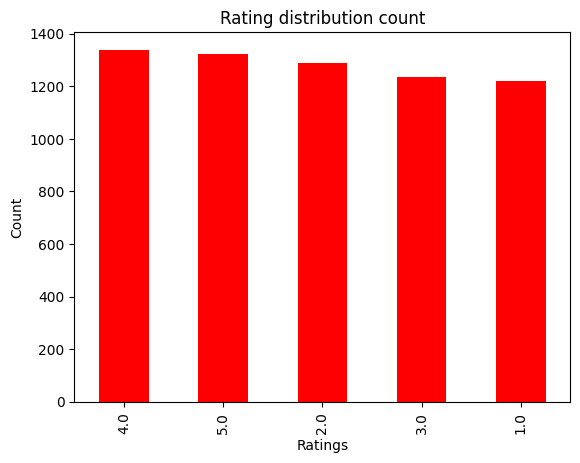

In [24]:
#Bar plot to visualize the total counts of each rating
data['Rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [25]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['Rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
Rating
4.0    20.91
5.0    20.66
2.0    20.10
3.0    19.28
1.0    19.05
Name: count, dtype: float64


Let's plot the above values in a pie chart

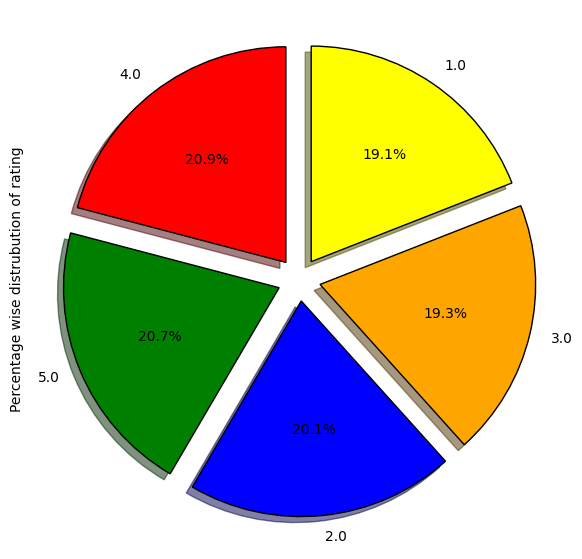

In [26]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue','orange','yellow')
wp = {'linewidth':1, "edgecolor":'black'}
tags = data['Rating'].value_counts()/data.shape[0]
explode=(0.1,0.1,0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')
from io import  BytesIO
graph = BytesIO()
fig.savefig(graph, format="png")

### Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [27]:
#Distinct values of 'feedback' and its count 

print(f"Feedback value count: \n{data['Feedback'].value_counts()}")

Feedback value count: 
Feedback
1.0    3223
0.0    3181
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [28]:
#Extracting the 'Review Text' value for one record with feedback = 0
review_0 = data[data['Feedback'] == 0].iloc[1]['Review Text']
print(review_0)

The hospital lacked organization, and communication between departments was poor. This led to delays and unnecessary stress.


In [29]:
#Extracting the 'Review Text' value for one record with feedback = 1
review_1 = data[data['Feedback'] == 1].iloc[1]['Review Text']
print(review_1)

My experience here was wonderful/positive/stress-free. The staff went out of their way to make everything seamless.


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

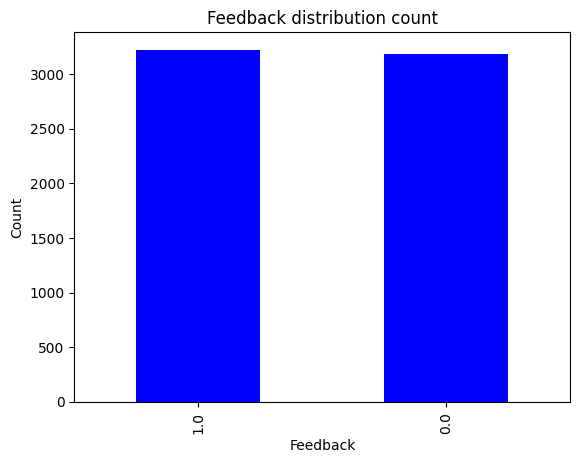

In [30]:
#Bar graph to visualize the total counts of each feedback
data['Feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [31]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records
print(f"Feedback value count - percentage distribution: \n{round(data['Feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
Feedback
1.0    50.33
0.0    49.67
Name: count, dtype: float64


Feedback distribution <br>
* 50.22% reviews are positive <br>
* 49.78% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

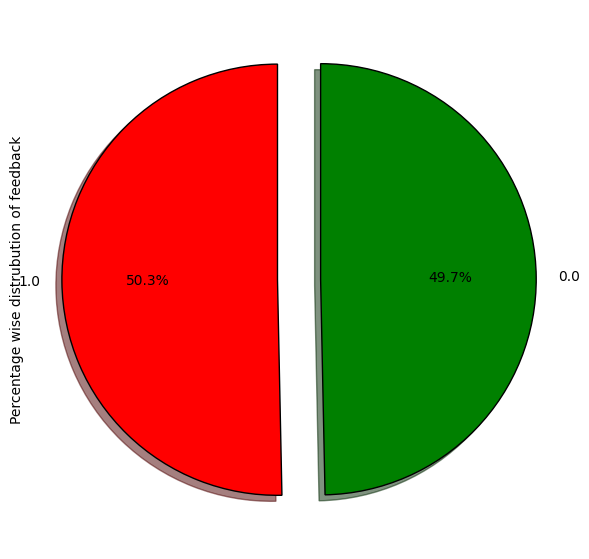

In [32]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green')
wp = {'linewidth':1, "edgecolor":'black'}
tags = data['Feedback'].value_counts()/data.shape[0]
explode=(0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

Let's see the 'rating' values for different values of 'feedback'

In [33]:
#Feedback = 0
data[data['Feedback'] == 0]['Rating'].value_counts()

Rating
2.0    683
3.0    643
1.0    625
4.0    619
5.0    611
Name: count, dtype: int64

In [34]:
#Feedback = 1
data[data['Feedback'] == 1]['Rating'].value_counts()

Rating
4.0    720
5.0    712
2.0    604
1.0    595
3.0    592
Name: count, dtype: int64

### Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [35]:
#Distinct values of 'variation' and its count 

print(f"Hospital Name value count: \n{data['Hospital Name'].value_counts()}")

Hospital Name value count: 
Hospital Name
Central Health Care         1670
City Hospital               1598
St. Mary's Clinic           1573
Greenwood Medical Center    1563
Name: count, dtype: int64


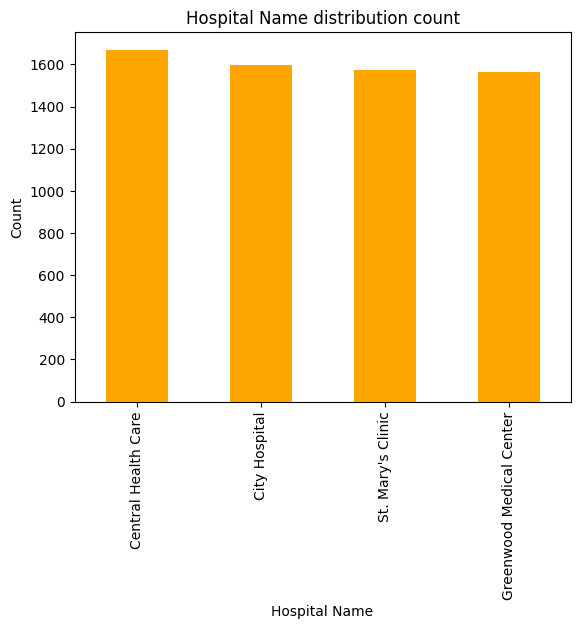

In [36]:
#Bar graph to visualize the total counts of each variation

data['Hospital Name'].value_counts().plot.bar(color = 'orange')
plt.title('Hospital Name distribution count')
plt.xlabel('Hospital Name')
plt.ylabel('Count')
plt.show()

In [37]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

print(f"Hospital Name value count - percentage distribution: \n{round(data['Hospital Name'].value_counts()/data.shape[0]*100,2)}")

Hospital Name value count - percentage distribution: 
Hospital Name
Central Health Care         26.08
City Hospital               24.95
St. Mary's Clinic           24.56
Greenwood Medical Center    24.41
Name: count, dtype: float64


Mean rating according to variation

In [38]:
data.groupby('Hospital Name')['Rating'].mean()

Hospital Name
Central Health Care         3.001796
City Hospital               3.057572
Greenwood Medical Center    3.079974
St. Mary's Clinic           3.024158
Name: Rating, dtype: float64

Let's analyze the above ratings

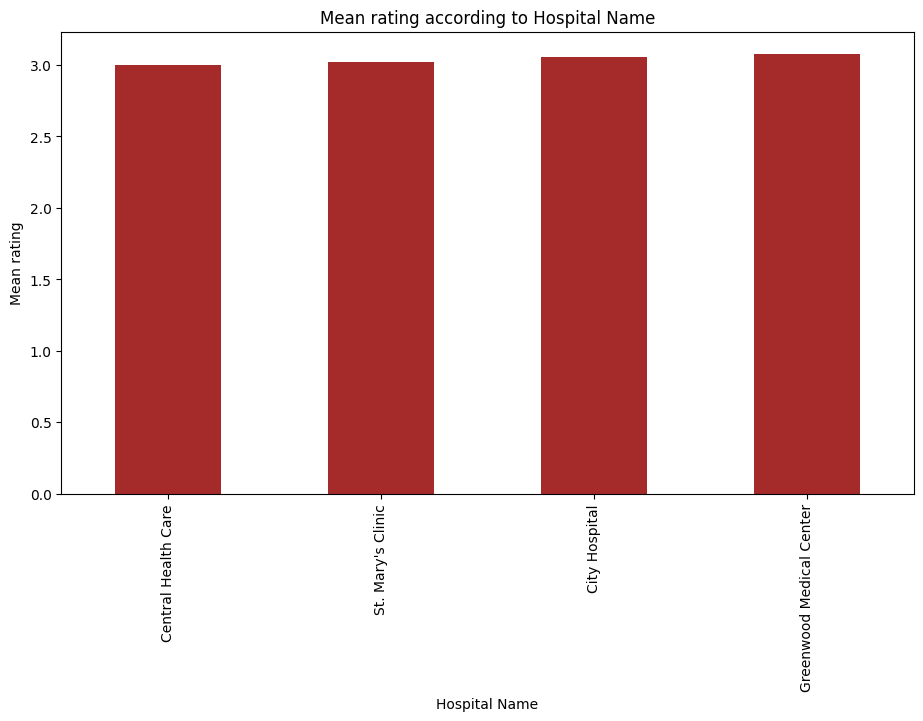

In [39]:
data.groupby('Hospital Name')['Rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to Hospital Name")
plt.xlabel('Hospital Name')
plt.ylabel('Mean rating')
plt.show()

### Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [40]:
data['length'].describe()

count    6404.000000
mean       95.155996
std        35.683608
min        19.000000
25%        64.000000
50%       106.000000
75%       119.000000
max       241.000000
Name: length, dtype: float64

Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

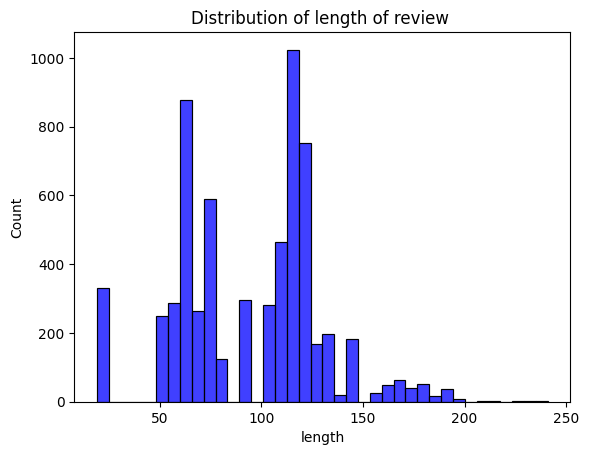

In [41]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

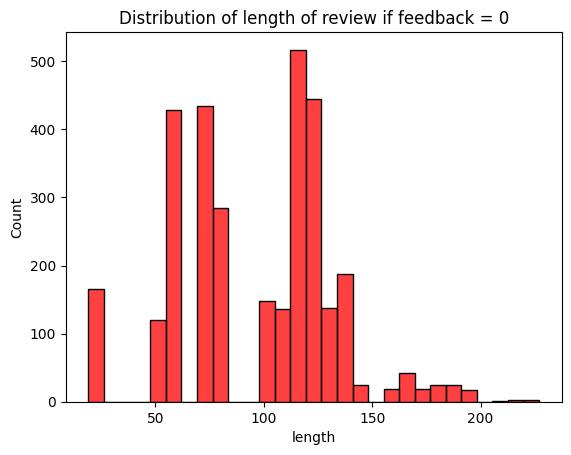

In [42]:
sns.histplot(data[data['Feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

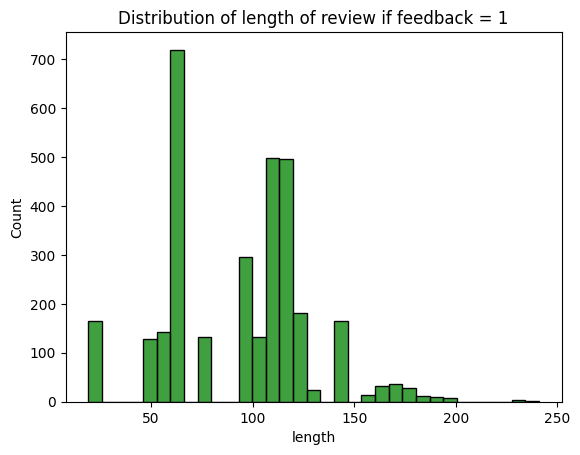

In [43]:
sns.histplot(data[data['Feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

Lengthwise mean rating

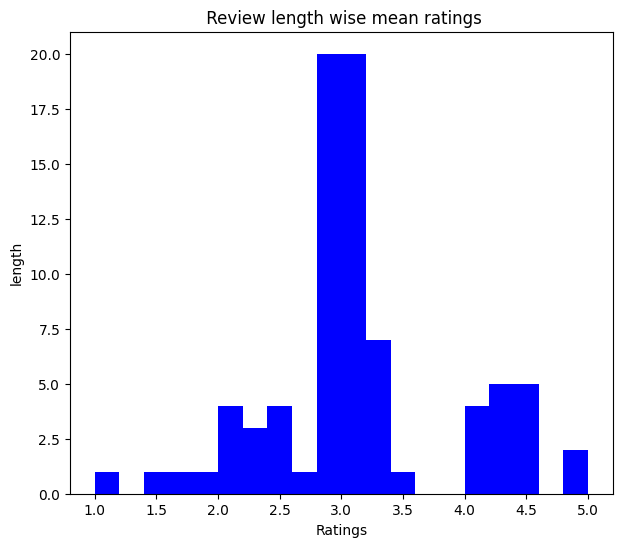

In [44]:
data.groupby('length')['Rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('Ratings')
plt.ylabel('length')
plt.show()

In [45]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data['Review Text'])

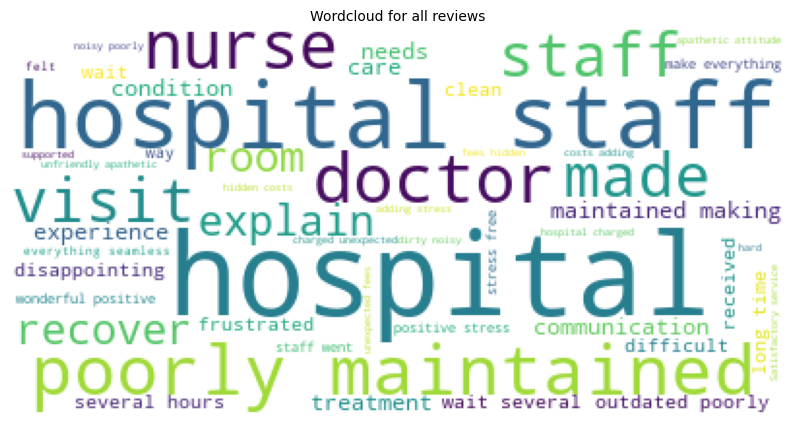

In [46]:
# Combine all reviews
reviews = " ".join([review for review in data['Review Text']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [47]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['Feedback'] == 0]['Review Text']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['Feedback'] == 1]['Review Text']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


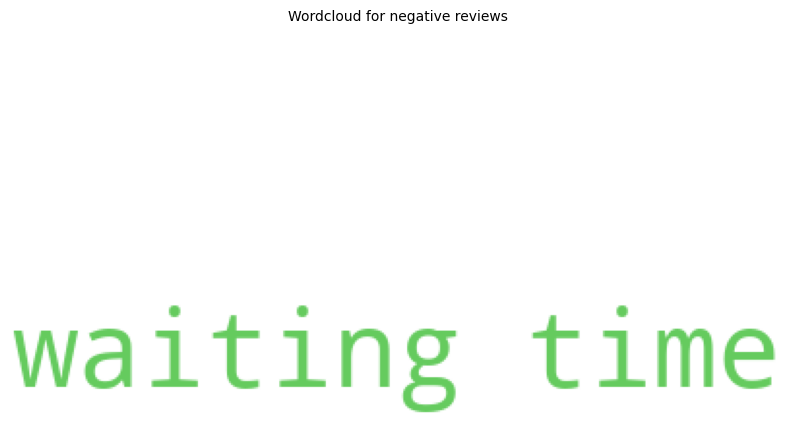

In [79]:
wc = WordCloud(background_color='white', max_words=100)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

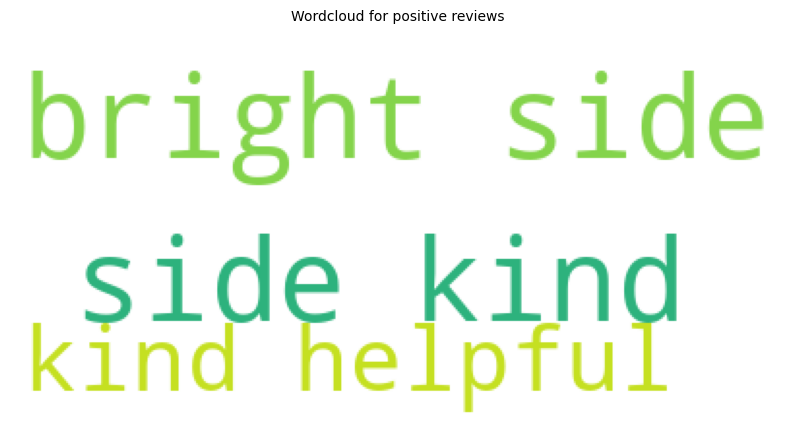

In [49]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [50]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['Review Text'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

Using Count Vectorizer to create bag of words

In [51]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['Feedback'].values

In [52]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Count_Vectorizer101.pkl', 'wb'))

Checking the shape of X and y

In [53]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (6404, 177)
y shape: (6404,)


Splitting data into train and test set with 30% data with testing.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (4482, 177)
y train: (4482,)
X test: (1922, 177)
y test: (1922,)


In [55]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 3
X test max value: 3


We'll scale X_train and X_test so that all values are between 0 and 1.

In [56]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [57]:
#Saving the scaler model
pickle.dump(scaler, open('Scaler202.pkl', 'wb'))

#### Random Forest

In [58]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [59]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.99776885319054
Testing Accuracy : 0.9968782518210197


In [60]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [61]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

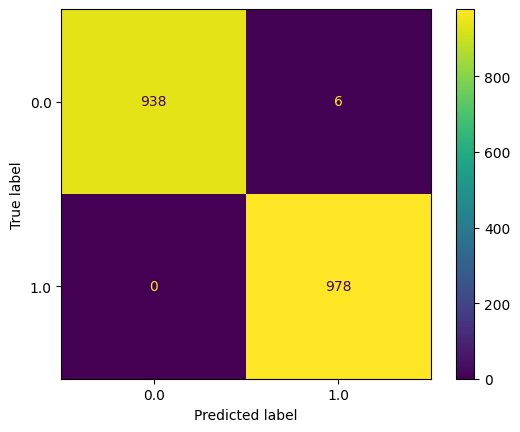

In [62]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [63]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9973224228444163
Standard Variance : 0.0021862344768023892


Applying grid search to get the optimal parameters on random forest

In [64]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [65]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [66]:
#Getting the best parameters from the grid search

print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 100}


In [67]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 99.776885319054
Cross validation mean accuracy on test set : 99.7211066488175
Accuracy score for test set : 0.9968782518210197


#### XgBoost

In [68]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [69]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.99776885319054
Testing Accuracy : 0.9968782518210197


In [70]:
y_preds = model_xgb.predict(X_test)

In [71]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[938   6]
 [  0 978]]


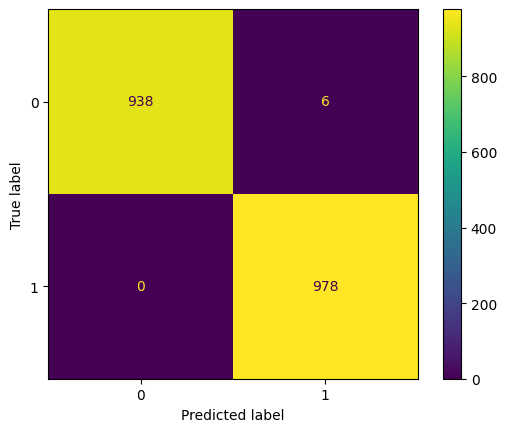

In [72]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [73]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('model_xgb303.pkl', 'wb'))

#### Decision Tree Classifier

In [74]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [75]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.99776885319054
Testing Accuracy : 0.9968782518210197


In [76]:
y_preds = model_dt.predict(X_test)

In [77]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[938   6]
 [  0 978]]


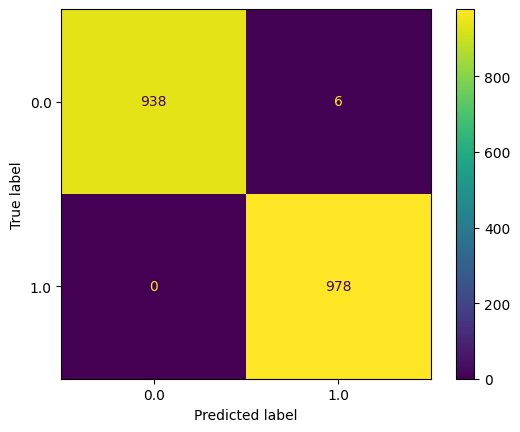

In [78]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()